# Homework 2

## Markets

### UChicago Financial Mathematics

#### September 2024

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# Data

Use the data file `../data/treasury_quotes_<DATE>.xlsx`.
* replace `<DATE>` with `2024-05-31`
* consider this the date at the time of valuation.

In [60]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import fsolve
from scipy.optimize import root
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pyprojroot import here
import os 
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# SETTINGS
pd.set_option('display.float_format', '{:.4f}'.format) # Limiting floats output to 4 decimal points

# Set working directory
os.chdir("/Users/charleston/Downloads/git_repositories/finm-fixedincome-2025")
 
# DATE
quote_date = '2024-05-31'

# DATA
quotes = pd.read_excel(here(f"./data/treasury_quotes_{quote_date}_old.xlsx"), sheet_name="quotes", index_col=0)
selected_quotes = pd.read_excel(here(f"./data/treasury_quotes_{quote_date}_old.xlsx"), sheet_name="selected quotes", index_col=0)

***

# 1. Treasury Debt Composition

### Data
Use the data in the `quotes` tab.

## 1.1
Plot the total amount of outstanding debt maturing at each date

* Do this for `total size`, as that is listed for T-bills.
* (You could also examine `public size`, but that will exclude T-bills.)

Tip: `.pivot_table()` may be useful.

In [61]:
# Calculate the debt and aggregate it to the annual level
debt = quotes.pivot_table(values='total size', index = 'maturity date', columns= 'type', aggfunc='sum') \
    .resample('Y').sum()
debt['TIPS'] = debt['TIPS bond'] + debt['TIPS note']
debt.drop(['TIPS bond', 'TIPS note'], axis=1, inplace=True)


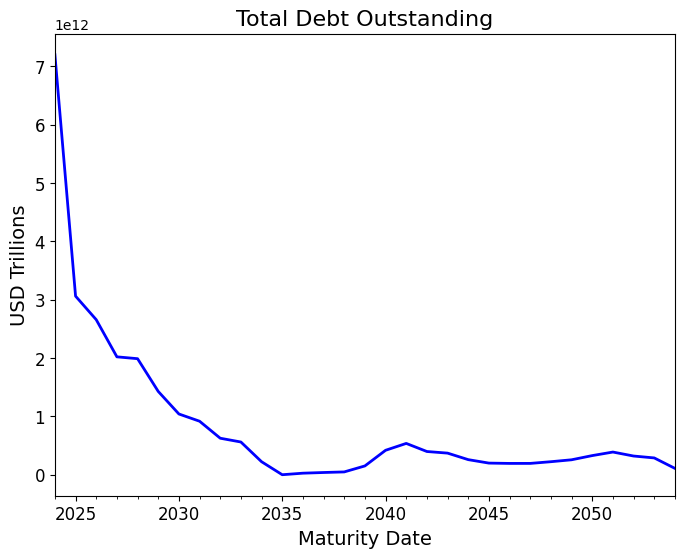

In [62]:
# Plot the total debt outstanding
debt.sum(axis=1).plot(figsize=(8, 6), linewidth=2, color='b')

# Customize the plot
plt.title('Total Debt Outstanding', fontsize=16)
plt.xlabel('Maturity Date', fontsize=14)
plt.ylabel('USD Trillions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS.

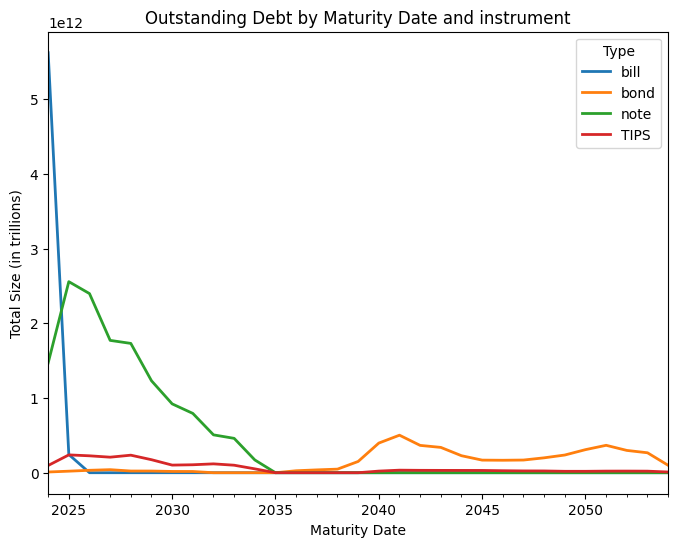

In [63]:
debt.plot(figsize=(8, 6), linewidth=2)
plt.title('Outstanding Debt by Maturity Date and instrument')
plt.xlabel('Maturity Date')
plt.ylabel('Total Size (in trillions)')
plt.legend(title='Type')
plt.grid(False)
plt.show()

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

In [64]:
debt.sum(axis = 0).to_frame().rename(columns={0:'Total Outstanding Debt'}).style.format('{:,.0f}')

,Total Outstanding Debt
type,
bill,"5,866,778,000,000"
bond,"4,560,331,000,000"
note,"14,013,743,000,000"
TIPS,"2,025,754,000,000"


## 1.4
Make a pie chart of this total number (reported in 1.3.) 

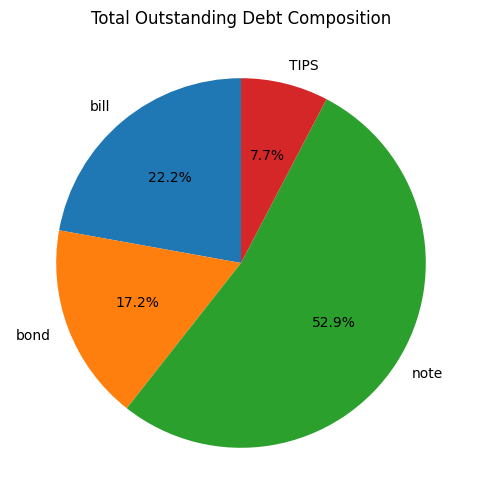

In [65]:
debt.sum(axis=0).plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(10, 6))
plt.title('Total Outstanding Debt Composition')
plt.ylabel('')
plt.show()

## 1.5

Calculate the time-to-maturity (relative to the quoted date) for each issue.

Report the summary statistics of these time-to-maturities. 

Consider using `.describe()`

In [66]:
quotes['ttm'] = (quotes['maturity date'] - pd.Timestamp(quote_date)).dt.days / 365
quotes['ttm'].describe().to_frame().rename(columns={'ttm': 'time-to-maturity'}).T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
time-to-maturity,446.00,6.83,8.25,0.01,1.08,3.23,7.94,29.98


***

# 2 YTM and Price

The problems in this section ask you to calculate the **yield-to-maturity (YTM)** of various bonds.

You will need to use a nonlinear solver to solve for the YTM.

For any given bond, YTM ($y$) solves...

$$p = \sum_{i=1}^{2n}\frac{Fc/2}{(1+y/2)^i} + \frac{F}{(1+y/2)^{2n}}$$

where
* $p$ is the bond's price.
* $n$ is the number of years to maturity
* $c$ is the coupon rate (a percentage)
* $F$ is the face value. Use $F=100$

#### Solving for YTM
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. This function is imported with...

`from scipy.optimize import fsolve`

## 2.1

Consider a semiannual bond with the following stylized parameters:
* time-to-maturity of 30 years
* coupon rate: 3%
* Face value of 100

1. Assume the YTM is 5%. Calculate the price.
1. Assume the price is 87. Calculate the YTM.

In [68]:
# Note that the price bond is a generalization of the formula provided. 
def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        #accr_frac = 1 - (T-round(T))*cpnfreq        
        accr_frac = 0

    if cpn==0:
        accr_frac = 0
        
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price

def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None,solver='fsolve',x0=.01):
    
    pv_wrapper = lambda y: price - price_bond(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)

    if solver == 'fsolve':
        ytm = fsolve(pv_wrapper,x0)
    elif solver == 'root':
        ytm = root(pv_wrapper,x0)
    return ytm

In [69]:
# 1. Calculate the price assuming the YTM is 5%
price_bond(0.05, 30, 0.03, cpnfreq=2, face=100, accr_frac=None)


69.09134351494251

In [71]:
# 2. Calculate the YTM assuming the price is 87
ytm(87, 30, 0.03, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=.01)

array([0.03723107])

## 2.2

### Data
Use the data in the `selected quotes` tab.
* It gives treasury bond data for various maturities, spaced roughly six months apart.
* Feel free to approximate the time-to-maturity to be exactly semiannually if that is easier for the problem below.
* Use the `price` column for the price data in the YTM formula. (No need to worry about "dirty" price, bid, ask, nor accrued interest.)

1. Calculate the yield-to-maturity for each issue. How close are your calculations to the provided column `ytm`?

1. Plot the time-to-maturity (TTM) against the calculated YTM.

In [77]:
yieldcurve = pd.DataFrame(index=selected_quotes.index,columns=['ttm','ytm provided','ytm calculated'],dtype=float)

for i in selected_quotes.index:
    yieldcurve.loc[i,'ytm calculated'] = ytm(selected_quotes.loc[i,'price'], selected_quotes.loc[i,'ttm'], selected_quotes.loc[i,'cpn rate']/100,x0=.02)

yieldcurve['ttm'] = selected_quotes['ttm']
yieldcurve['ytm provided'] = selected_quotes['ytm']

In [78]:
yieldcurve

,ttm,ytm provided,ytm calculated
KYTREASNO,,,
207971,0.5010,0.0535,0.0536
208056,0.9993,0.0520,0.0520
208143,1.5003,0.0505,0.0505
208227,1.9986,0.0488,0.0487
207804,2.4997,0.0476,0.0476
207887,2.9979,0.0468,0.0468
207973,3.4990,0.0463,0.0463
208058,4.0000,0.0458,0.0458
208145,4.5010,0.0454,0.0454


In [79]:
# Vectorized functions
def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = np.asarray(ytm) / cpnfreq
    cpn_n = np.asarray(cpn) / cpnfreq
    T = np.asarray(T)

    if accr_frac is None:
        accr_frac = np.zeros_like(T)
    else:
        accr_frac = np.asarray(accr_frac)
    
    cpn_zero_mask = np.asarray(cpn) == 0
    accr_frac = np.where(cpn_zero_mask, 0, accr_frac)

    N = T * cpnfreq
    price = face * (
        (cpn_n / ytm_n) * (1 - (1 + ytm_n) ** -N) + (1 + ytm_n) ** -N
    ) * (1 + ytm_n) ** accr_frac
    return price

def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=0.01):
    # Ensure all inputs are NumPy arrays
    price = np.asarray(price)
    T = np.asarray(T)
    cpn = np.asarray(cpn)
    
    if accr_frac is None:
        accr_frac = np.zeros_like(T)
    else:
        accr_frac = np.asarray(accr_frac)
    
    # Wrapper to calculate YTM for a single instance
    def calculate_ytm_single(p, t, c, f, a):
        pv_wrapper = lambda y: p - price_bond(y, t, c, cpnfreq=f, face=face, accr_frac=a)
        if solver == 'fsolve':
            return fsolve(pv_wrapper, x0)[0]  # Extract the single result
        elif solver == 'root':
            return root(pv_wrapper, x0).x[0]  # Extract the single result
    
    # Vectorized calculation across all input values
    ytm_results = np.vectorize(calculate_ytm_single, otypes=[float])(price, T, cpn, cpnfreq, accr_frac)
    return ytm_results

In [88]:
# Step 1: Extract input arrays from the DataFrame
prices = selected_quotes['price']
ttms = selected_quotes['ttm']
cpn_rates = selected_quotes['cpn rate']/ 100  # Convert to decimal rate
x0 = 0.02  # Initial guess for YTM

# Step 2: Calculate YTM for all rows at once
calculated_ytms = ytm(price=prices, T=ttms, cpn=cpn_rates, x0=x0)

# Step 3: Populate the yieldcurve DataFrame
yieldcurve = pd.DataFrame({
    'ttm': selected_quotes['ttm'],
    'ytm provided': selected_quotes['ytm'],
    'ytm calculated': calculated_ytms
})

In [89]:
yieldcurve

,ttm,ytm provided,ytm calculated
KYTREASNO,,,
207971,0.5010,0.0535,0.0536
208056,0.9993,0.0520,0.0520
208143,1.5003,0.0505,0.0505
208227,1.9986,0.0488,0.0487
207804,2.4997,0.0476,0.0476
207887,2.9979,0.0468,0.0468
207973,3.4990,0.0463,0.0463
208058,4.0000,0.0458,0.0458
208145,4.5010,0.0454,0.0454


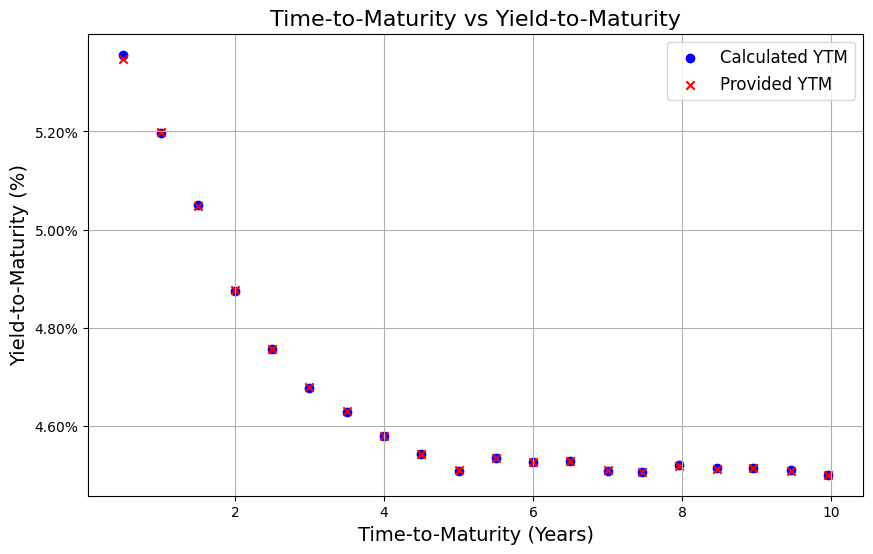

In [96]:
plt.figure(figsize=(10, 6))
plt.scatter(yieldcurve['ttm'], yieldcurve['ytm calculated'], label='Calculated YTM', color='b', marker='o')
plt.scatter(yieldcurve['ttm'], yieldcurve['ytm provided'], label='Provided YTM', color='r', marker='x')
plt.title('Time-to-Maturity vs Yield-to-Maturity', fontsize=16)
plt.xlabel('Time-to-Maturity (Years)', fontsize=14)
plt.ylabel('Yield-to-Maturity (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

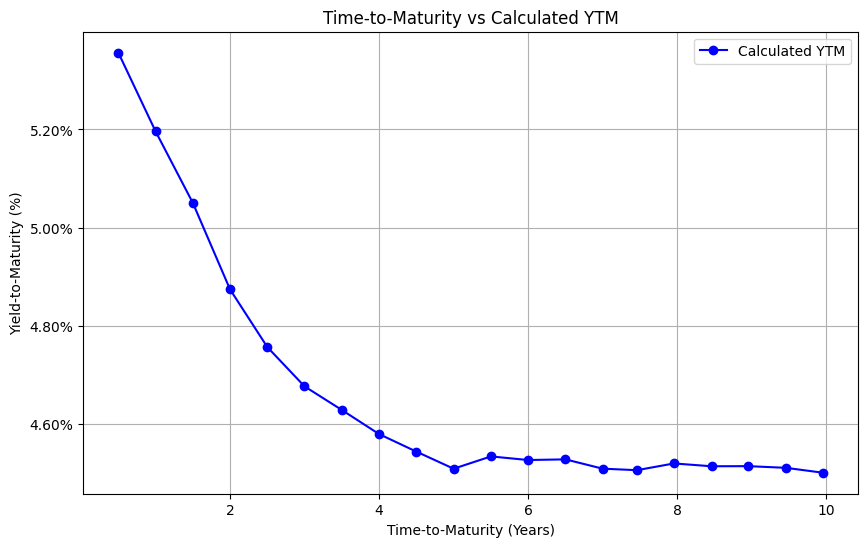

In [95]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
plt.plot(yieldcurve['ttm'], yieldcurve['ytm calculated'], marker='o', linestyle='-', color='b', label='Calculated YTM')
plt.title('Time-to-Maturity vs Calculated YTM')
plt.xlabel('Time-to-Maturity (Years)')
plt.ylabel('Yield-to-Maturity (%)')
plt.legend()
plt.grid(True)

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

***

# 3. Extra

If you would like to go further with computing yields, try these problems.

### Data
Use the data in the `selected quotes` tab.

Focus on the nominal securities. 
* Exclude any row with `type` of `TIPS note` or `TIPS bond`.

In [105]:
quotes_filtered = quotes[~quotes['type'].isin(['TIPS bond', 'TIPS note'])]

## 3.1
Plot the time-to-maturity against the provided YTM.

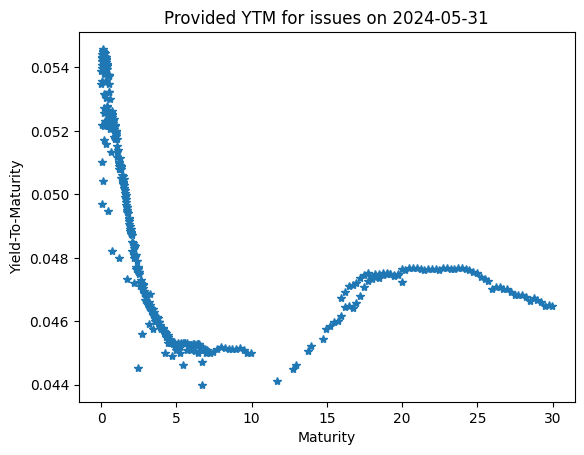

In [106]:
plt.plot(quotes_filtered['ttm'], quotes_filtered['ytm'],linestyle='',marker='*')
plt.title(f'Provided YTM for issues on {pd.to_datetime(quote_date):%Y-%m-%d}')
plt.ylabel('Yield-To-Maturity')
plt.xlabel('Maturity')
plt.show()

## 3.2

1. Calculate the YTM of each (nominal) bond issue in the data set. 

1. Report how far your YTM calculation is from those reported in the data set.

1. Report your calculated YTM for the issues where the dataset does not provide a YTM.


In [109]:
# Step 1: Extract input arrays from the DataFrame
prices = quotes_filtered['price']
ttms = quotes_filtered['ttm']
cpn_rates = quotes_filtered['cpn rate']/ 100  # Convert to decimal rate
x0 = 0.02  # Initial guess for YTM

# Step 2: Calculate YTM for all rows at once
calculated_ytms = ytm(price=prices, T=ttms, cpn=cpn_rates, x0=x0)

# Step 3: Populate the yieldcurve DataFrame
yieldcurve = pd.DataFrame({
    'ttm': quotes_filtered['ttm'],
    'ytm provided': quotes_filtered['ytm'],
    'ytm calculated': calculated_ytms
})

In [110]:
yieldcurve

,ttm,ytm provided,ytm calculated
KYTREASNO,,,
208166,0.0110,0.0535,0.0534
208141,0.0164,0.0539,0.0539
208179,0.0301,0.0541,0.0540
208072,0.0356,0.0540,0.0539
207730,0.0411,0.0497,0.0497
...,...,...,...
208062,28.9753,0.0467,0.0467
208107,29.2274,0.0466,0.0466
208149,29.4795,0.0465,0.0465


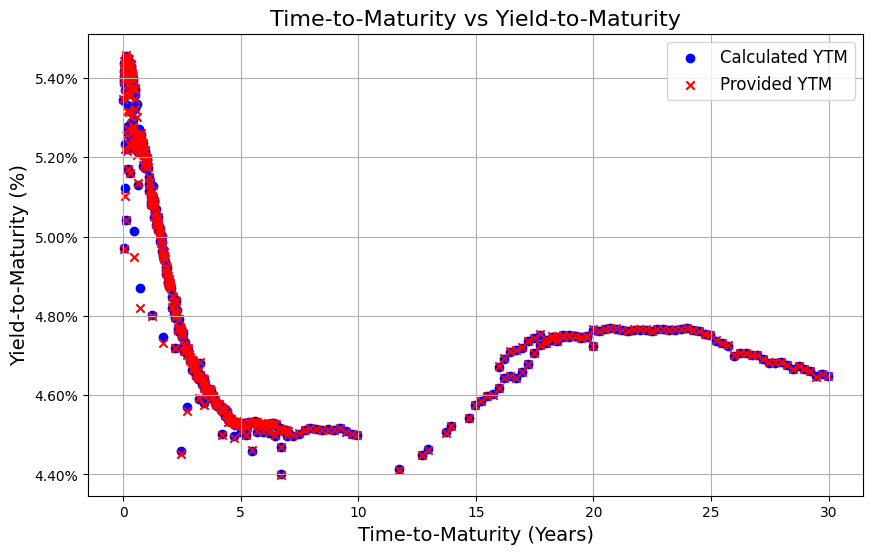

In [111]:
plt.figure(figsize=(10, 6))
plt.scatter(yieldcurve['ttm'], yieldcurve['ytm calculated'], label='Calculated YTM', color='b', marker='o')
plt.scatter(yieldcurve['ttm'], yieldcurve['ytm provided'], label='Provided YTM', color='r', marker='x')
plt.title('Time-to-Maturity vs Yield-to-Maturity', fontsize=16)
plt.xlabel('Time-to-Maturity (Years)', fontsize=14)
plt.ylabel('Yield-to-Maturity (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

In [112]:
(yieldcurve['ytm calculated'] - yieldcurve['ytm provided']).astype(float).describe().to_frame().rename(columns={0:'summary'}).style.format('{:.6f}')

,summary
count,393.000000
mean,0.000008
std,0.000072
min,-0.000057
25%,-0.000026
50%,-0.000008
75%,0.000006
max,0.000658


In [114]:
yieldcurve[yieldcurve['ytm provided'].isna()]

,ttm,ytm provided,ytm calculated
KYTREASNO,,,




## 3.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `type`=`bill` or looking for `cpnrate` of 0.

In [127]:
tbills.head()

,type,quote date,issue date,total size,public size,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,discount yield
KYTREASNO,,,,,,,,,,,,,,,,
208166,bill,2024-05-31,2024-02-06,205786000000.0000,NaN,2024-06-04,0.0110,0.9781,0.0000,99.9422,99.9423,99.9422,0.0000,99.9422,0.0535,0.0535
208141,bill,2024-05-31,2023-12-07,213564000000.0000,NaN,2024-06-06,0.0164,0.9671,0.0000,99.9126,99.9128,99.9127,0.0000,99.9127,0.0539,0.0539
208179,bill,2024-05-31,2024-02-13,215789000000.0000,NaN,2024-06-11,0.0301,0.9398,0.0000,99.8393,99.8396,99.8394,0.0000,99.8394,0.0541,0.0540
208072,bill,2024-05-31,2023-06-15,253965000000.0000,NaN,2024-06-13,0.0356,0.9288,0.0000,99.8104,99.8108,99.8106,0.0000,99.8106,0.0540,0.0539
208180,bill,2024-05-31,2024-02-20,215784000000.0000,NaN,2024-06-18,0.0493,0.9014,0.0000,99.7355,99.7360,99.7357,0.0000,99.7357,0.0544,0.0543


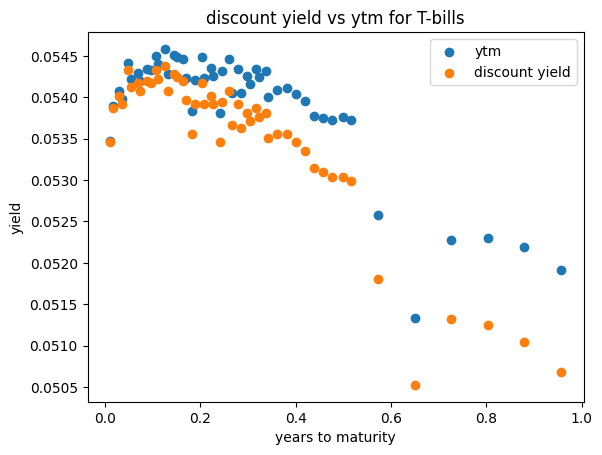

In [128]:
DAYCT_ADJ = 360/365

tbills = quotes[quotes['type'] == 'bill']
idx = tbills.index

tbills['discount yield'] = ((100-tbills['price'])/100 / (tbills['ttm'] * DAYCT_ADJ)).to_frame().rename(columns={0:'discount yield'})

plt.figure()
plt.scatter(tbills.loc[idx,'ttm'],tbills.loc[idx,'ytm'],label= 'ytm')
plt.scatter(tbills.loc[idx,'ttm'],tbills.loc[idx,'discount yield'],label='discount yield')
plt.legend()
plt.ylabel('yield')
plt.xlabel('years to maturity')
plt.title('discount yield vs ytm for T-bills')
plt.show()

***